<a href="https://colab.research.google.com/github/thekhan314/CovidBrazilMod3/blob/master/COVID_REDUX_last_google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries and Functions


In [1]:
import sklearn

In [2]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.22.1.


In [75]:
from khantools import *
import pandas as pd
import numpy as np

import pprint as pp
import matplotlib.pyplot as plt
import seaborn as sns
import operator as operator

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

C:\Users\umark\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [4]:
# Evaluate empty columns
def cols_with_data(dataframe,threshold,plot=False,axis=0):
    ''' returns a series with all columns that are filled to at least threshold percentage or higher'''
    
    counts = dataframe.count(axis=axis).sort_values()
    
    if axis == 0: 
        counts = counts/len(dataframe)
    else:
        counts = counts/len(dataframe.columns)
        
    non_zero_cols = counts[counts >= threshold ]
    
    if plot == True:
        fig,ax = plt.subplots()
        ax.barh(non_zero_cols.index,non_zero_cols)
        fig.set_size_inches(6,9)
        fig.show()
        print("Features left:{}".format(len(non_zero_cols)))
    return non_zero_cols

def value_counts (df,value, oper):
    ''' takes in a datframe of float values, returns count of zero values '''
    dict = {}
    
    ops = {'>': operator.gt,
           '<': operator.lt,
           '>=': operator.ge,
           '<=': operator.le,
           '=': operator.eq}
    
    for col in df.columns:
        matches = sum(ops[oper](df[col],value))
        
        dict[col] = matches
    
    df = pd.Series(dict)
    return df


Lets import the data and run a preliminary report

In [5]:
df = pd.read_excel('dataset.xlsx')
report_prelim = report1(df,5)

It appears that the most commonly occuring values aside from the ones that are always there is what appears to be a battery of standard tests. I think it might be a good idea to discard all the rows where these tests were not performed, as they are much too sparse to be of any use to us. Lets keep only rows where standard tests were done, and see if that leaves us with enough data to make a meaningful model.

In [6]:
df = df[df['Parainfluenza 2'].notnull()]
report_post_trim = report1(df,6)
print(len(df))
#display(report_post_trim)

1352


# Data Cleanup and sorting

## Rename & Clean Columns

In [7]:
# Lets change the names of some columns to something easier to work with
new_names = {
    'Patient addmited to intensive care unit (1=yes, 0=no)':'intensive',
    'Patient addmited to semi-intensive unit (1=yes, 0=no)':'semi_int',
    'Patient addmited to regular ward (1=yes, 0=no)':'reg_ward',
    'SARS-Cov-2 exam result':'sars_cov2',
    'Patient age quantile':'age_quant',
    'Patient ID':'patient_id'
}

df = df.rename(columns=new_names)
df.set_index(keys='patient_id',inplace=True)

# convert age_quant to float

df['age_quant'] = df['age_quant'].astype(float)
#delete empty columns

empty_cols = list(report_post_trim[report_post_trim['% empty'] == 100.0].index)
df = df.drop(columns=empty_cols)



## Reduce features

In [8]:
# all data: filled values in each column 
col_fill = cols_with_data(df,threshold=0.03)

meaty_cols = list(col_fill[col_fill > 0.1].index)
meaty_cols.append('Lactic Dehydrogenase')

df = df[meaty_cols]

## Subset features

In [9]:
df_types = df.dtypes

float_features = list(df_types[df_types == 'float64'].index)
obj_features = list(df_types[df_types == 'object'].index)

high_imp= ['Lactic Dehydrogenase','Lymphocytes','Proteina C reativa mg/dL']
admission_features = ['intensive','semi_int','reg_ward']



for col in admission_features:
    df[col] = df[col].astype(float)

## Convert Categoricals

In [10]:
report2 = report1(df[obj_features],3).sort_values('unique values')
display(report2)

,type,% empty,unique values,1nth_value,1nth_value_%,2nth_value,2nth_value_%
Parainfluenza 2,object,0.00,1,not_detected,100.00,NaN,NaN
"Influenza B, rapid test",object,80.40,2,negative,18.49,positive,1.11
Rhinovirus/Enterovirus,object,0.00,2,not_detected,71.97,detected,28.03
sars_cov2,object,0.00,2,negative,91.72,positive,8.28
Inf A H1N1 2009,object,0.00,2,not_detected,92.75,detected,7.25
Influenza B,object,0.00,2,not_detected,94.38,detected,5.62
Respiratory Syncytial Virus,object,0.00,2,not_detected,96.15,detected,3.85
CoronavirusNL63,object,0.00,2,not_detected,96.67,detected,3.33
Coronavirus HKU1,object,0.00,2,not_detected,98.52,detected,1.48
"Influenza A, rapid test",object,80.40,2,negative,18.20,positive,1.41


Lets also drop all the unary features because it seems they are all basically negative and dont seem to add much information.

Lets convert the binary categoricals to floats. 

For tests that have a 'not done' value, I will treat 'not done' as negative, since its safe to assume if t he test wasnt done the doctor was expecting a negative anyways. 

Urine Aspect color and crystals I will drop. They dont sound too important, and dont comprise alot of rows.I will also drop standard tests, as I feel they will only add noise.  

Urine PH and Urine Leukocytes should be converted to float



In [11]:
binary_conversions = list(report2[report2['unique values'] == 2].index)

for col in binary_conversions:
    df[col] = df[col].replace(['not_detected','negative','absent','normal'],0)
    df[col] = df[col].replace(['detected','positive','not_done'],1)
    df[col] = df[col].astype(float)

df['sars_cov2'] = df['sars_cov2'].replace(['negative'],0)
df['sars_cov2'] = df['sars_cov2'].replace(['positive'],1)
df.drop('Parainfluenza 2',axis=1,inplace=True)

report3 = report1(df,6)

display(report3)

,type,% empty,unique values,1nth_value,1nth_value_%,2nth_value,2nth_value_%,3nth_value,3nth_value_%,4nth_value,4nth_value_%,5nth_value,5nth_value_%,6nth_value,6nth_value_%
Bordetella pertussis,float64,0.00,2,0.000000,99.85,1.000000,0.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Parainfluenza 1,float64,0.00,2,0.000000,99.78,1.000000,0.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CoronavirusOC43,float64,0.00,2,0.000000,99.41,1.000000,0.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Coronavirus229E,float64,0.00,2,0.000000,99.33,1.000000,0.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chlamydophila pneumoniae,float64,0.00,2,0.000000,99.33,1.000000,0.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Parainfluenza 3,float64,0.00,2,0.000000,99.26,1.000000,0.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Adenovirus,float64,0.00,2,0.000000,99.04,1.000000,0.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Metapneumovirus,float64,0.00,2,0.000000,98.96,1.000000,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Influenza A,float64,0.00,2,0.000000,98.67,1.000000,1.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Parainfluenza 4,float64,0.00,2,0.000000,98.59,1.000000,1.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Fill Empties

In [12]:
full_cols = cols_with_data(df,1)
full_feats = list(full_cols.index)

unfull_feats = list(df.drop(full_feats,axis=1).columns)


In [13]:
filled_feats = full_feats.copy()


for feature in unfull_feats:
    df_vals_present = df.loc[df[feature].notnull()]
    
    X = df_vals_present[filled_feats]
    y = df_vals_present[feature]
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    if feature in float_features:
        pipe = Ridge(alpha=0.5)
       
        
    elif feature in obj_features:
        
        pipe = LogisticRegression(C=1e5, solver='lbfgs',class_weight='balanced',max_iter=10000)
        
    
    pipe.fit(X,y)
    
    df_predictors = df.loc[df[feature].isna()][filled_feats]
    y_hat = pipe.predict(df_predictors)
    
    df.loc[df[feature].isna(),feature] = y_hat
    
    filled_feats.append(feature)

In [14]:
display(report1(df,4))

,type,% empty,unique values,1nth_value,1nth_value_%,2nth_value,2nth_value_%,3nth_value,3nth_value_%,4nth_value,4nth_value_%
Bordetella pertussis,float64,0.0,2,0.000000,99.85,1.000000,0.15,NaN,NaN,NaN,NaN
Parainfluenza 1,float64,0.0,2,0.000000,99.78,1.000000,0.22,NaN,NaN,NaN,NaN
CoronavirusOC43,float64,0.0,2,0.000000,99.41,1.000000,0.59,NaN,NaN,NaN,NaN
Chlamydophila pneumoniae,float64,0.0,2,0.000000,99.33,1.000000,0.67,NaN,NaN,NaN,NaN
Coronavirus229E,float64,0.0,2,0.000000,99.33,1.000000,0.67,NaN,NaN,NaN,NaN
Parainfluenza 3,float64,0.0,2,0.000000,99.26,1.000000,0.74,NaN,NaN,NaN,NaN
Adenovirus,float64,0.0,2,0.000000,99.04,1.000000,0.96,NaN,NaN,NaN,NaN
Metapneumovirus,float64,0.0,2,0.000000,98.96,1.000000,1.04,NaN,NaN,NaN,NaN
Influenza A,float64,0.0,2,0.000000,98.67,1.000000,1.33,NaN,NaN,NaN,NaN
"Influenza A, rapid test",float64,0.0,2,0.000000,98.59,1.000000,1.41,NaN,NaN,NaN,NaN


## Unified target column

In [15]:
for feat in admission_features:
    df.loc[df[feat] == 1,'adm_status'] = feat

df['adm_status'].fillna(value='not_adm',inplace=True)
df = df.drop(columns=admission_features)

# Train Classifiers

In [35]:
smote = SMOTE()

X = df.drop('adm_status',axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

y = df['adm_status']

X_train, X_test, y_train, y_test = train_test_split(X,y,  test_size=0.25, random_state=42)

X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train) 

## Baseline Model 

### Confusion Matrix

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   24.0s finished
C:\Users\umark\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\umark\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

   intensive       0.70      0.70      0.70        10
     not_adm       0.99      0.92      0.95       305
    reg_ward       0.39      0.56      0.46        16
    semi_int       0.10      0.29      0.14         7

    accuracy                           0.88       338
   macro avg       0.54      0.62      0.56       338
weighted avg       0.93      0.88      0.90       338



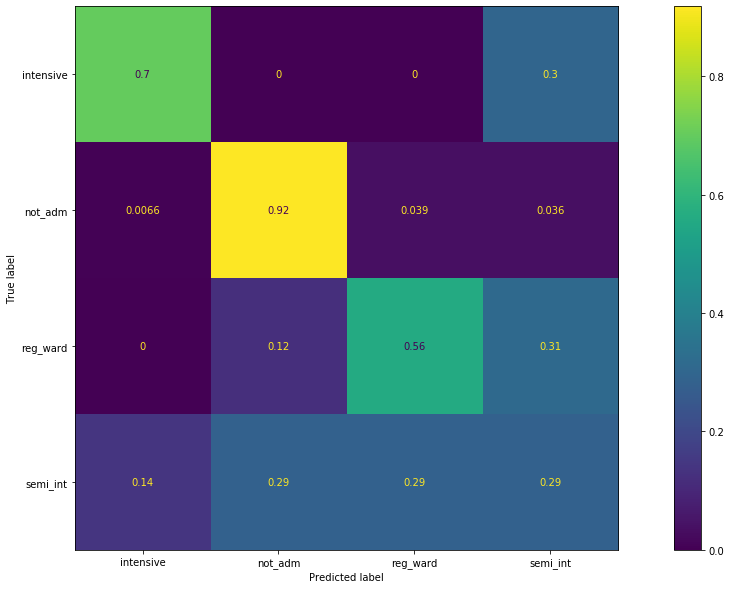

In [36]:
clf = LogisticRegression()

params = {
    'C': [1e3,1e5,1e10,1e20],
    'solver':['lbfgs', 'liblinear'],
    'max_iter':[10,100],
}

clf = LogisticRegression()

gs_base = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
)

gs_base.fit(X_train_smote,y_train_smote)

base_clf = gs_base.best_estimator_

base_clf.fit(X_train_smote,y_train_smote)

fig,ax = plt.subplots(figsize=(20,10))
base_cf_plot = plot_confusion_matrix(base_clf,X_test,y_test,ax=ax,normalize='true')

y_pred = base_clf.predict(X_test)

print(classification_report(y_test,y_pred))

It seems that the 'semi intensive' category is the worst performing one. It might be a better idea to relabel "semit_intensive" data points as something else. Lets look at teh ROC curves to see if its even worthwhile trying to predict semi intensive. 


### ROC Curves by label

In [18]:
smote = SMOTE()

X = df.drop('adm_status',axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

label_list = df['adm_status'].value_counts().index.to_list()
y = label_binarize(df['adm_status'],label_list)

X_train, X_test, y_train, y_test = train_test_split(X,y,  test_size=0.25, random_state=42)

X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 

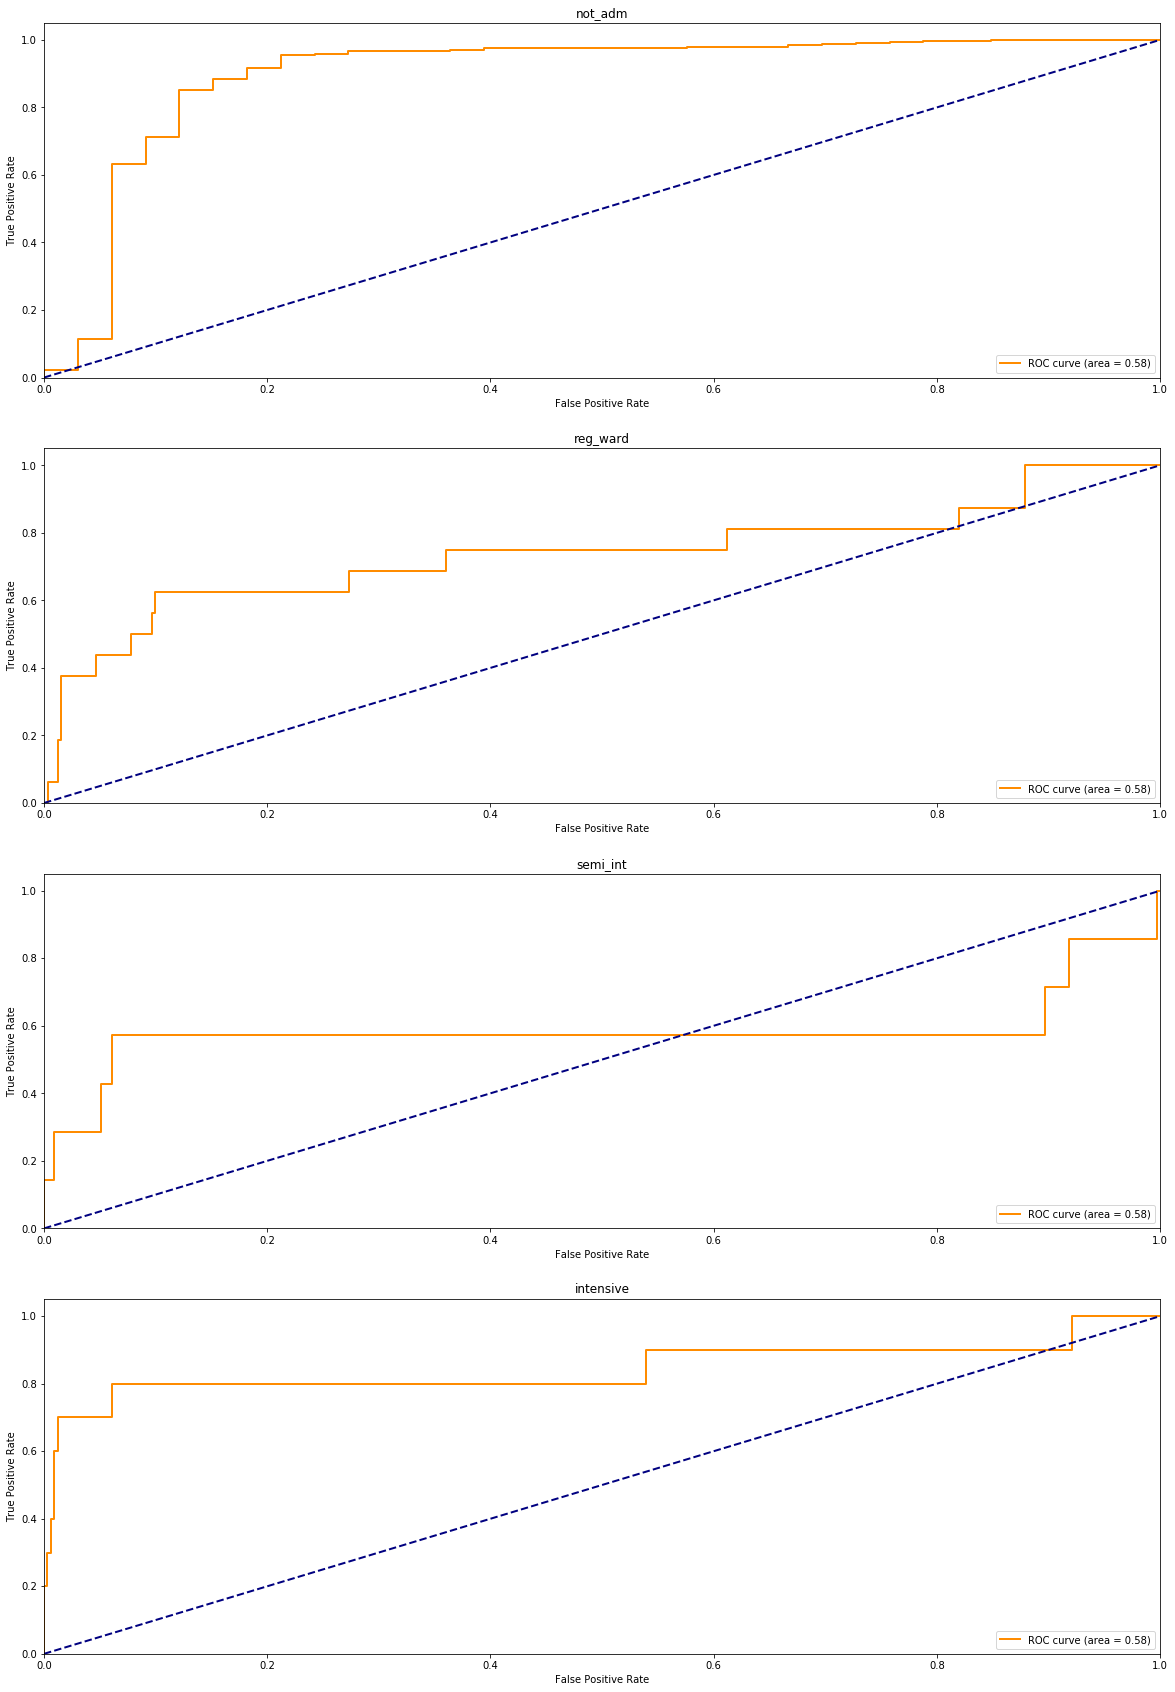

In [19]:
estimator = LogisticRegression(C=1000, solver='liblinear',multi_class='ovr',max_iter=100)

clf = OneVsRestClassifier(estimator)

clf.fit(X_train_resampled,y_train_resampled)

y_score = clf.decision_function(X_test)
y_pred = clf.predict(X_test)
n_classes = y.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fig,ax = plt.subplots(len(label_list),figsize=(20,30))

for i in range(0,len(label_list)):
    ax[i].plot(fpr[i], tpr[i], color='darkorange',
            lw=2, label='ROC curve (area = %0.2f)' % roc_auc[2])
    ax[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[i].set_xlim([0.0, 1.0])
    ax[i].set_ylim([0.0, 1.05])
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')
    ax[i].set_title(label_list[i])
    ax[i].legend(loc="lower right")



Yes, semi intensive is definitely not a very useful label to predict, we may as well randomly guess. What we will do is relabel all semi intensive data points as either regular ward or intensive using logistic regression. 

### Relabel and retry

In [70]:
df2 = df.copy()

semi_indexes = df2.loc[df2['adm_status'] == 'semi_int',:].index.to_list()

df_train = df2.drop(semi_indexes,axis=0)

X = df_train.drop('adm_status',axis=1)
y = df_train['adm_status']

X_test = df2.loc[semi_indexes,:].drop('adm_status',axis=1)

weight_dict = {
    'not_adm': 1,
    'reg_ward': 10,
    'intensive': 70
}

clf = LogisticRegression(C=1000,max_iter=100,solver='liblinear',class_weight=weight_dict)

clf.fit(X,y)

y_predict = clf.predict(X_test)

df2.loc[semi_indexes,'adm_status'] = y_predict

In [27]:
smote = SMOTE()

X = df2.drop('adm_status',axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

y = df2['adm_status']

X_train, X_test, y_train, y_test = train_test_split(X,y,  test_size=0.25, random_state=42)

X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train) 

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   11.6s finished


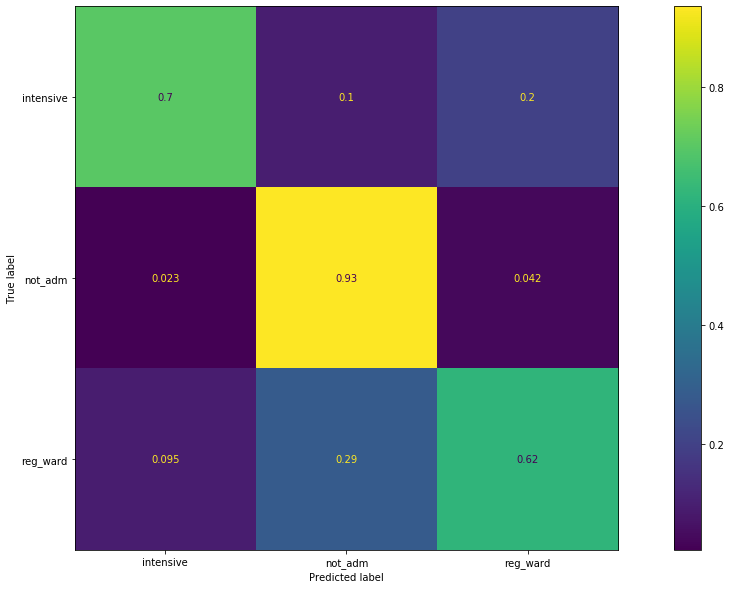

In [28]:
clf = LogisticRegression()

params = {
    'C': [1e3,1e5,1e10,1e20],
    'solver':['lbfgs', 'liblinear'],
    'max_iter':[10,100],
}

clf = LogisticRegression()

gs_base = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
)

gs_base.fit(X_train_smote,y_train_smote)

base_clf = gs_base.best_estimator_

base_clf.fit(X_train_smote,y_train_smote)

fig,ax = plt.subplots(figsize=(20,10))
base_cf_plot = plot_confusion_matrix(base_clf,X_test,y_test,ax=ax,normalize='true')

In [32]:
y_pred = base_clf.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

   intensive       0.44      0.70      0.54        10
     not_adm       0.98      0.93      0.96       307
    reg_ward       0.46      0.62      0.53        21

    accuracy                           0.91       338
   macro avg       0.63      0.75      0.67       338
weighted avg       0.93      0.91      0.92       338



Yes that certainly seems to have helped. The recall on precision the reg_ward category has gone up. THe precision for intensive has gone down, but the recall is the same which is good. I think its more important to maximize recall for the intensive category, even if it leads to lower precision as the consequences of false negatives are far more dire than those of false positives.

## Logistic Regresison

### Weights Dictionary

Lets try a more expanded range of Logistic Regression parameters. Lets use explicit weight dictionaries, and lets try to optimize for the recall of intensive. 

In [44]:
clf = LogisticRegression()

params = {
    'C': [1e3,1e5,1e10,1e20],
    'solver':['lbfgs', 'liblinear'],
    'max_iter':[10,100],
}

clf = LogisticRegression()

scorer = make_scorer(f1_score, labels=['intensive'],average = 'macro')
gs_base = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)

gs_base.fit(X_train_smote,y_train_smote)

base_clf = gs_base.best_estimator_

base_clf.fit(X_train_smote,y_train_smote)

fig,ax = plt.subplots(figsize=(20,10))
base_cf_plot = plot_confusion_matrix(base_clf,X_test,y_test,ax=ax,normalize='true')

y_pred = base_clf.predict(X_test)

print(classification_report(y_test,y_pred))

In [50]:
weights_dict = [{
    'not_adm':1,
    'reg_ward':20,
    'intensive':60
},{
    'not_adm':1,
    'reg_ward':15,
    'intensive':50
},{
    'not_adm':1,
    'reg_ward':30,
    'intensive':60
},{
    'not_adm':1,
    'reg_ward':40,
    'intensive':100
}
]

In [51]:
clf = LogisticRegression()


params = {
    'C': [1e3,1e5,1e10,1e20],
    'solver':['lbfgs', 'liblinear'],
    'max_iter':[10,100,1000],
    'class_weight':weights_dict
}

scorer = make_scorer(recall_score, labels=['intensive'],average = 'macro')

gs_logistic = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)
gs_logistic.fit(X_train,y_train)

clf = gs_logistic.best_estimator_

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

class_report_1 = classification_report(y_test,y_pred)

print(class_report_1)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:   28.8s


              precision    recall  f1-score   support

   intensive       0.20      0.80      0.31        10
     not_adm       0.98      0.83      0.90       307
    reg_ward       0.28      0.52      0.37        21

    accuracy                           0.81       338
   macro avg       0.49      0.72      0.53       338
weighted avg       0.92      0.81      0.85       338



[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   55.1s finished
C:\Users\umark\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\umark\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

So we found a model with 80% recall but with a much lower precision of only 20%. Perhaps we should try maximizing for the f1 score for intensive instead. 

In [52]:
clf = LogisticRegression()


params = {
    'C': [1e3,1e5,1e10,1e20],
    'solver':['lbfgs', 'liblinear'],
    'max_iter':[10,100,1000],
    'class_weight':weights_dict
}

scorer = make_scorer(f1_score, labels=['intensive'],average = 'macro')

gs_logistic = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)
gs_logistic.fit(X_train,y_train)

clf = gs_logistic.best_estimator_

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

class_report_1 = classification_report(y_test,y_pred)

print(class_report_1)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:   28.7s


              precision    recall  f1-score   support

   intensive       0.40      0.60      0.48        10
     not_adm       0.97      0.96      0.96       307
    reg_ward       0.50      0.43      0.46        21

    accuracy                           0.92       338
   macro avg       0.62      0.66      0.64       338
weighted avg       0.92      0.92      0.92       338



[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   58.3s finished
C:\Users\umark\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\umark\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


The precision rose but recall went down to .60. Thats the best balance it seems we can find for those two metrics. Maybe SMOTE is a better option. 

### SMOTE

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  73 out of  80 | elapsed:    8.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   11.4s finished


              precision    recall  f1-score   support

   intensive       0.41      0.70      0.52        10
     not_adm       0.98      0.93      0.95       307
    reg_ward       0.45      0.67      0.54        21

    accuracy                           0.90       338
   macro avg       0.61      0.76      0.67       338
weighted avg       0.93      0.90      0.91       338



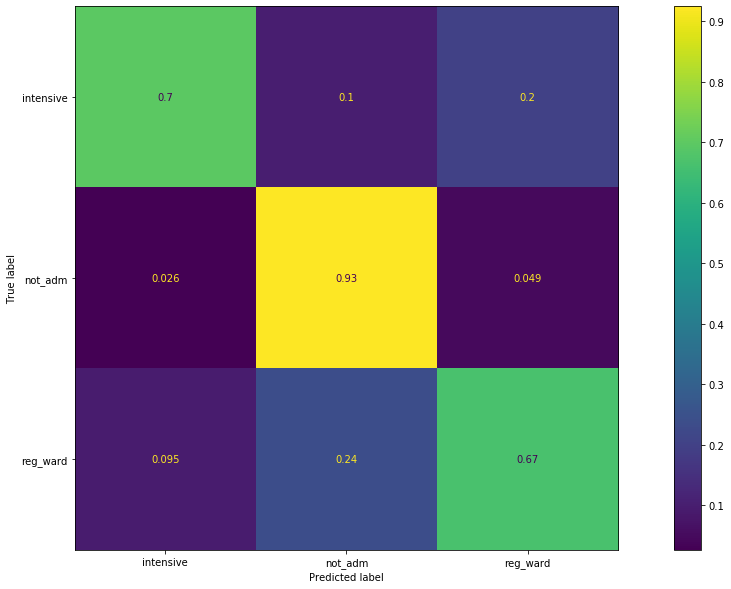

In [53]:
clf = LogisticRegression()

params = {
    'C': [1e3,1e5,1e10,1e20],
    'solver':['lbfgs', 'liblinear'],
    'max_iter':[10,100],
}

clf = LogisticRegression()

scorer = make_scorer(recall_score, labels=['intensive'],average = 'macro')
gs_base = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)

gs_base.fit(X_train_smote,y_train_smote)

base_clf = gs_base.best_estimator_

base_clf.fit(X_train_smote,y_train_smote)

fig,ax = plt.subplots(figsize=(20,10))
base_cf_plot = plot_confusion_matrix(base_clf,X_test,y_test,ax=ax,normalize='true')

y_pred = base_clf.predict(X_test)

print(classification_report(y_test,y_pred))

SLightly lower recall on intensive compared to the best recall from explicit class weights. However, better precision for both intensive and ref_Ward and much better recall for reg_Ward. 

Lets see if the best f1 returns a recall score thats acceptable for intensive

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  73 out of  80 | elapsed:    8.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   12.0s finished


              precision    recall  f1-score   support

   intensive       0.41      0.70      0.52        10
     not_adm       0.98      0.93      0.95       307
    reg_ward       0.45      0.67      0.54        21

    accuracy                           0.90       338
   macro avg       0.61      0.76      0.67       338
weighted avg       0.93      0.90      0.91       338



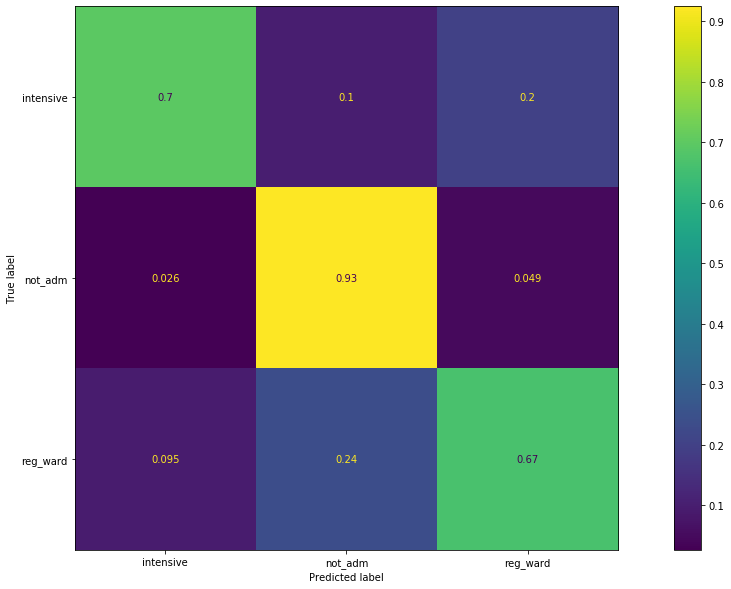

In [54]:
clf = LogisticRegression()

params = {
    'C': [1e3,1e5,1e10,1e20],
    'solver':['lbfgs', 'liblinear'],
    'max_iter':[10,100],
}

clf = LogisticRegression()

scorer = make_scorer(f1_score, labels=['intensive'],average = 'macro')
gs_base = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)

gs_base.fit(X_train_smote,y_train_smote)

base_clf = gs_base.best_estimator_

base_clf.fit(X_train_smote,y_train_smote)

fig,ax = plt.subplots(figsize=(20,10))
base_cf_plot = plot_confusion_matrix(base_clf,X_test,y_test,ax=ax,normalize='true')

y_pred = base_clf.predict(X_test)

print(classification_report(y_test,y_pred))

Looks like the model with the highest recall for intensive also has the highest f1 for intensive. 

I want to try one last thing. Instead of using regression to fill semi_int, i want to just replace semi_int labels with reg_Ward. IT seems since we took semi_int out, the performance for reg ward went up, but the precision for intensive was lowered. So this means the semi_int points probably help classifiers find reg_ward candidates but create noise when it comes to intensive. 

### re-relabel

In [66]:
df3 = df.copy()

df3['adm_status'].replace('semi_int','reg_ward',inplace=True)

X = df3.drop('adm_status',axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)


y = df3['adm_status']

X_train, X_test, y_train, y_test = train_test_split(X,y,  test_size=0.25, random_state=42)

smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train) 



Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   15.0s finished


              precision    recall  f1-score   support

   intensive       0.60      0.60      0.60        10
     not_adm       0.97      0.93      0.95       305
    reg_ward       0.44      0.65      0.53        23

    accuracy                           0.91       338
   macro avg       0.67      0.73      0.69       338
weighted avg       0.92      0.91      0.91       338



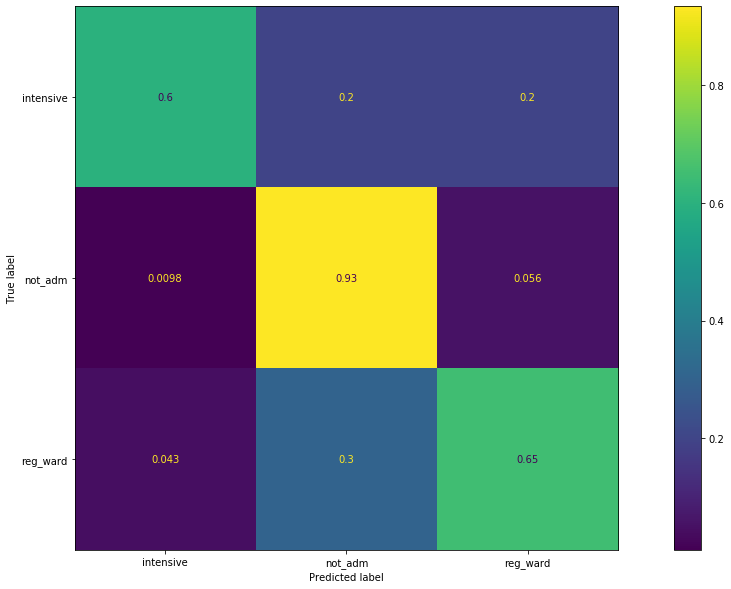

In [68]:
clf = LogisticRegression()

params = {
    'C': [1e3,1e5,1e10,1e20],
    'solver':['lbfgs', 'liblinear'],
    'max_iter':[10,100],
}

clf = LogisticRegression()

scorer = make_scorer(f1_score, labels=['intensive'],average = 'macro')
gs_base = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)

gs_base.fit(X_train_smote,y_train_smote)

base_clf = gs_base.best_estimator_

base_clf.fit(X_train_smote,y_train_smote)

fig,ax = plt.subplots(figsize=(20,10))
base_cf_plot = plot_confusion_matrix(base_clf,X_test,y_test,ax=ax,normalize='true')

y_pred = base_clf.predict(X_test)

print(classification_report(y_test,y_pred))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   12.3s finished


              precision    recall  f1-score   support

   intensive       0.60      0.60      0.60        10
     not_adm       0.97      0.93      0.95       305
    reg_ward       0.44      0.65      0.53        23

    accuracy                           0.91       338
   macro avg       0.67      0.73      0.69       338
weighted avg       0.92      0.91      0.91       338



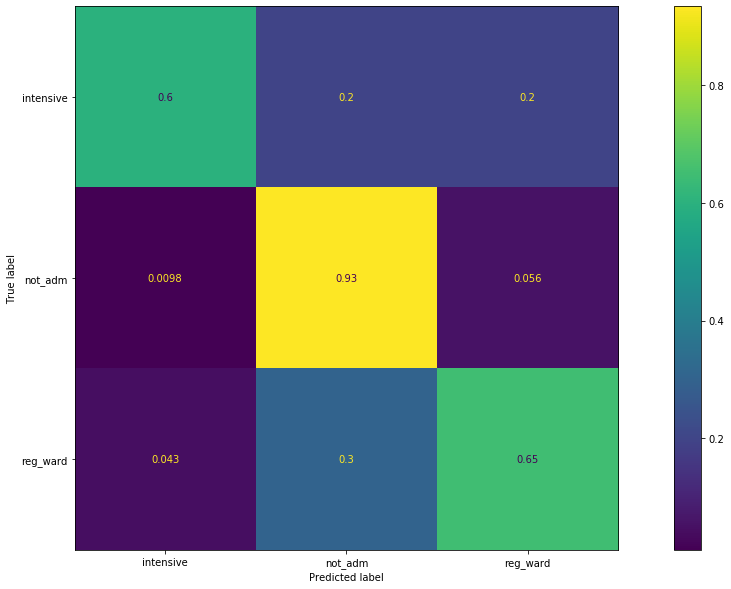

In [69]:
clf = LogisticRegression()

params = {
    'C': [1e3,1e5,1e10,1e20],
    'solver':['lbfgs', 'liblinear'],
    'max_iter':[10,100],
}

clf = LogisticRegression()

scorer = make_scorer(recall_score, labels=['intensive'],average = 'macro')
gs_base = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)

gs_base.fit(X_train_smote,y_train_smote)

base_clf = gs_base.best_estimator_

base_clf.fit(X_train_smote,y_train_smote)

fig,ax = plt.subplots(figsize=(20,10))
base_cf_plot = plot_confusion_matrix(base_clf,X_test,y_test,ax=ax,normalize='true')

y_pred = base_clf.predict(X_test)

print(classification_report(y_test,y_pred))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   15.0s finished


              precision    recall  f1-score   support

   intensive       0.60      0.60      0.60        10
     not_adm       0.97      0.93      0.95       305
    reg_ward       0.44      0.65      0.53        23

    accuracy                           0.91       338
   macro avg       0.67      0.73      0.69       338
weighted avg       0.92      0.91      0.91       338



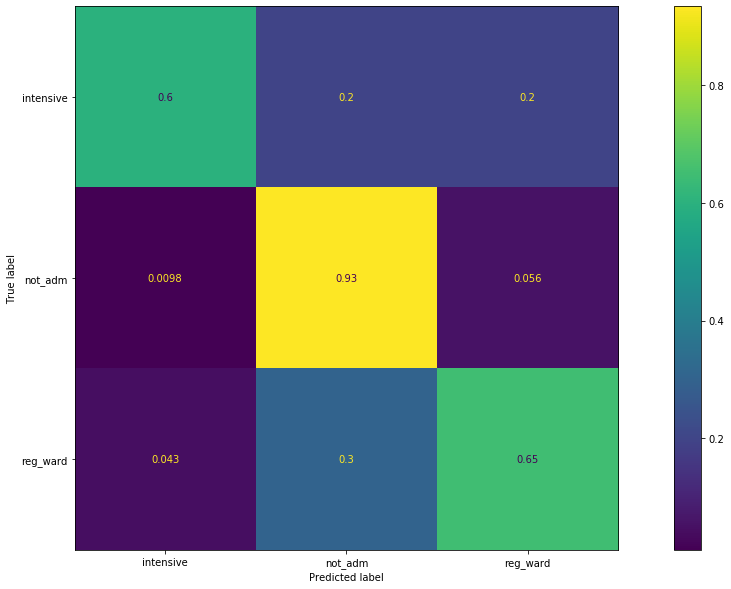

In [68]:
clf = LogisticRegression()

params = {
    'C': [1e3,1e5,1e10,1e20],
    'solver':['lbfgs', 'liblinear'],
    'max_iter':[10,100],
}

clf = LogisticRegression()

scorer = make_scorer(f1_score, labels=['intensive'],average = 'macro')
gs_base = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)

gs_base.fit(X_train_smote,y_train_smote)

base_clf = gs_base.best_estimator_

base_clf.fit(X_train_smote,y_train_smote)

fig,ax = plt.subplots(figsize=(20,10))
base_cf_plot = plot_confusion_matrix(base_clf,X_test,y_test,ax=ax,normalize='true')

y_pred = base_clf.predict(X_test)

print(classification_report(y_test,y_pred))

Hmm. Looks like we were able to increase the precision for intensive, but recall for intensive went down with little improvement in other metrics. Given that recall is more improtant, lets stay with out previous method of using regression to relabel semi_int, as that seems to have kept recall for intensive up. 

## K Nearest Neighbors

In [71]:
smote = SMOTE()

X = df2.drop('adm_status',axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

y = df2['adm_status']

X_train, X_test, y_train, y_test = train_test_split(X,y,  test_size=0.25, random_state=42)

X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train) 

In [76]:
clf = KNeighborsClassifier()

params = {
    'n_neighbors': [i for i in range(10,20)],
    'weights':['uniform','distance'],
    'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size':[5,10,15,20,25,30,40],
    'p':[i for i in range(1,4)]
}

scorer = make_scorer(f1_score, labels=['intensive'],average = 'macro')

gs_kneighb_class = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)

gs_kneighb_class.fit(X_train_smote,y_train_smote)

clf = gs_kneighb_class.best_estimator_

clf.fit(X_train_smote,y_train_smote)

y_pred = clf.predict(X_test)

class_report_1 = classification_report(y_test,y_pred)

print(class_report_1)

Fitting 5 folds for each of 1680 candidates, totalling 8400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 30.9min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 38.3min
[Parallel(n_jobs=-1)]: Done 8400 out of 8400 | elapsed: 46.4min finished


NameError: name 'y_smote' is not defined

In [77]:
clf.fit(X_train_smote,y_train_smote)

y_pred = clf.predict(X_test)

class_report_1 = classification_report(y_test,y_pred)

print(class_report_1)

              precision    recall  f1-score   support

   intensive       0.40      0.60      0.48        10
     not_adm       0.99      0.94      0.96       307
    reg_ward       0.40      0.57      0.47        21

    accuracy                           0.91       338
   macro avg       0.60      0.70      0.64       338
weighted avg       0.93      0.91      0.92       338



In [78]:
gs_kneighb_class.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=5, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=12, p=1,
                     weights='distance')

## Decision Tree

In [81]:
clf = DecisionTreeClassifier()

params = {
    'criterion': ['entropy','gini'],
    'splitter':['best', 'random'],
    'max_depth':[i for i in np.linspace(1, 32, 8, endpoint=True)],
    'min_samples_split':[i for i in np.linspace(0.1, 1.0, 10, endpoint=True)],
    'min_samples_leaf':[i for i in np.linspace(0.1, 0.5, 5, endpoint=True)]
}

scorer = make_scorer(f1_score, labels=['intensive'],average = 'macro')

gs_dec_tree = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)
gs_dec_tree.fit(X_train_smote,y_train_smote)

clf = gs_dec_tree.best_estimator_

clf.fit(X_train_smote,y_train_smote)

y_pred = clf.predict(X_test)

class_report_1 = classification_report(y_test,y_pred)

print(class_report_1)

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1232 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3232 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 6032 tasks      | elapsed:   55.9s


              precision    recall  f1-score   support

   intensive       0.20      0.80      0.32        10
     not_adm       1.00      0.85      0.92       307
    reg_ward       0.19      0.33      0.24        21

    accuracy                           0.81       338
   macro avg       0.46      0.66      0.49       338
weighted avg       0.92      0.81      0.86       338



[Parallel(n_jobs=-1)]: Done 8000 out of 8000 | elapsed:  1.2min finished


## Random Forest

In [86]:
clf = RandomForestClassifier()

params = {
    'criterion': ['entropy','gini'],
    'max_depth':[2,6,14,24,32],
    'min_samples_split':[1,2,3,4,5,6,7,8,9,10],
    'min_samples_leaf':[0.1,0.2,0.3,0.4,0.5]
}

scorer = make_scorer(f1_score, labels=['intensive'],average = 'macro')

gs_random_forest = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)
gs_random_forest.fit(X_train_smote,y_train_smote)

clf = gs_random_forest.best_estimator_

clf.fit(X_train_smote,y_train_smote)

y_pred = clf.predict(X_test)

class_report_1 = classification_report(y_test,y_pred)

print(class_report_1)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  6.2min finished


              precision    recall  f1-score   support

   intensive       0.17      0.70      0.27        10
     not_adm       1.00      0.76      0.86       307
    reg_ward       0.23      0.67      0.34        21

    accuracy                           0.75       338
   macro avg       0.46      0.71      0.49       338
weighted avg       0.92      0.75      0.81       338



## XGboost

In [ ]:
import xgboost as xgb
clf = xgb.XGBClassifier( objective='multi:softmax', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10,scale_pos_weight=15)
clf.fit(X_train_resampled,y_train_resampled)

y_score = clf.predict(X_test)

class_report_1 = classification_report(y_test,y_score)

print(class_report_1)

## Support Vector Machines

In [ ]:
clf = SVC()

params = {
    'C':[1,100,1000],
    'kernel':['linear','poly','rbf','sigmoid'],
    'degree': [2,3,4],
    'gamma':['scale']
}

scorer = make_scorer(f1_score, labels=['intensive'],average = 'macro')
gs_svc = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)
gs_svc.fit(X_train_smote,y_train_smote)

clf = gs_svc.best_estimator_

clf.fit(X_train_smote,y_train_smote)

y_pred = clf.predict(X_test)

class_report_1 = classification_report(y_test,y_pred,output_dict=True)
report = pd.DataFrame(class_report_1)
print(report)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s


In [ ]:
clf = SVC()

params = {
    'C':[1,100,1000],
    'kernel':['linear','poly','rbf','sigmoid'],
    'degree': [3],
    'gamma':['scale'],
    'class_weight':[None,'balanced'],
}

scorer = make_scorer(recall_score, labels=['intensive'],average = 'macro')
gs_svc = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)
gs_svc.fit(X_train_smote,y_train_smote)

gs_svc.best_score_
gs_svc.best_params_


clf = gs_svc.best_estimator_

clf.fit(X_train_smote,y_train_smote)

y_pred = clf.predict(X_test)

class_report_1 = classification_report(y_test,y_pred)
report = pd.DataFrame(class_report_1)
print(class_report_1)

In [ ]:
from sklearn.metrics import precision_recall_curve
estimator = clf
ovr = OneVsRestClassifier(estimator)

ovr.fit(X_train_resampled,y_train_resampled)

y_score = ovr.decision_function(X_test)
y_pred = ovr.predict(X_test)
n_classes = y.shape[1]

precision = dict()
recall = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])

fig,ax = plt.subplots(len(label_list),figsize=(20,40))

for i in range(0,len(label_list)):
    ax[i].plot(recall[i],precision[i], color='darkorange',
            lw=2)
    
    ax[i].set_xlim([0.0, 1.0])
    ax[i].set_ylim([0.0, 1.05])
    ax[i].set_xlabel('recall')
    ax[i].set_ylabel('precision')
    ax[i].set_title(label_list[i])
    ax[i].legend(loc="lower right")
    
    